## Travelling salesman

Code to try and find a solution to the travelling salesman problem on the globe using object-oriented simulated annealing

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random

import csv
import smopy

#smopy tile server and basic options
tile_server = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
tile_size=512

In [20]:
# generate world map ((lat_min, long_min, lat_max, long_max) , z=zoom_level)
# play with the values here to view different areas -- note that the zoom level may be changed to something more appropriate
worldmap = smopy.Map((0, -120, 65, 120), z=2, tileserver=tile_server, tilesize=tile_size)
dublinmap = smopy.Map((52.5, -8.4, 55., -6), z=7)

In [21]:
class SalesmanAnneal:
    '''Solves the TSM problem using a simulated annealing approach'''
    
    def __init__(self, lats, lons, cities, basemap,  T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        '''initialise the solver, loads city coordinates/names from arguments '''
        self.cities = cities
        self.lats=lats
        self.lons=lons
        self.N = len(cities)
        self.basemap = basemap
        
        self.initial_route = np.random.permutation(np.arange(self.N))
        
        self.current_route = np.copy(self.initial_route)
        
        self.best_route = np.copy(self.current_route)
        
        #setting up fitness
        self.cur_fitness = self.fitness(self.current_route)
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        self.fitness_list = [self.cur_fitness]
        
        #annealing parameters
        self.T = 1.0E6 if T == -1 else T
        self.alpha = 0.999 if alpha == -1 else alpha
        self.stopping_temperature = 0.0001 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
        
    def fitness(self, route):
        '''returns the "fitness", i.e. total RETURN path length.'''
        path = 0
        for i in range(self.N - 1):
            path += self.gcd(route[i],route[i+1])
            
        path += self.gcd(route[-1],route[0])
        
        return path
    
    def anneal(self):
        '''simulated annealing to find solution'''
        
        # loop until stopping conditions are met
        #while  ?????:
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:    
            
            candidate = np.copy(self.current_route)
            
            # generate a new candidate solution
            r1,r2 = random.randint(0,self.N+1,2)
            
            if r1 < r2:
                f = np.take(candidate,range(r1,r2))
                candidate[r1:r2] = np.flip(f)
                
            if r1 > r2:
                F = np.take(candidate,range(r1,r2+len(candidate)),mode='wrap')
                F_f = np.flip(F)
                s1 = candidate[r1:]
                s2 = candidate[:r2]
                f1 = F_f[:len(s1)]
                f2 = F[:len(s2)]
                candidate[r1:] = f1
                candidate[:r2] = f2
                
            # accept the new candidate?
            self.accept(candidate)
            
            # update conditions
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list
            self.fitness_list.append(self.cur_fitness)
    
    def accept(self, candidate):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = self.fitness(candidate)
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.current_route = candidate
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.best_route = candidate
        
        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness -self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.current_route = candidate        
                
    def print_route(self, route):
        '''Outputs a pretty map showing a particular route'''
        
        #base map to print our route on
        fig, ax = plt.subplots(figsize=(10, 9))
        ax = plt.subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_xlim(0, self.basemap.w)
        ax.set_ylim(self.basemap.h, 0)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(self.basemap.img)
        
        #cities
          
        px, py= self.basemap.to_pixels(self.lats, self.lons)
        ax.plot(px, py, 'or')
        
        #include labels
        [ax.annotate(self.cities[i], xy=(px[i], py[i]), 
                     xytext=(px[i]+20, py[i]+5), color='k', size=8) 
         for i in route]
        
        
        #plot entire route -- including back to start city
        ppl = 100         #points per leg
        px1, py1 =[], []
        for i in range(0,self.N):
            leg_lat, leg_lon = self.gcd_path(route[i-1],route[i],ppl)
            px_temp, py_temp = self.basemap.to_pixels(leg_lat, leg_lon)
            px1.extend(px_temp)
            py1.extend(py_temp)
            
#         leg_lat, leg_lon = self.gcd_path(self.N-1,0,ppl)
        px_temp, py_temp = self.basemap.to_pixels(leg_lat, leg_lon)
        px1.extend(px_temp)
        py1.extend(py_temp)     
            
                
        ax.plot(px1, py1, 'or', ms=0.3)
        return fig, ax
        
               
    #other methods (e.g. GCD between two points, path route....)
    # The length of the shortest path between a and b
    def gcd(self, a, b):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        dlon = lon2 - lon1 
        dlat = lat2 - lat1 

        hav = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
        c = 2 * np.arctan2( np.sqrt(hav), np.sqrt(1-hav) ) 
        return 6371* c 


# A function that returns "num" points on the shortest path between a and b
    def gcd_path(self, a, b, num):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        d=self.gcd(a, b)
        f= np.linspace(0, 1, num)

        delta = d / 6371
        alpha = np.sin((1-f)*delta) / np.sin(delta)
        beta = np.sin(f*delta) / np.sin(delta)

        x = alpha * np.cos(lat1) * np.cos(lon1) + beta * np.cos(lat2) * np.cos(lon2)
        y = alpha * np.cos(lat1) * np.sin(lon1) + beta * np.cos(lat2) * np.sin(lon2)
        z = alpha * np.sin(lat1) + beta * np.sin(lat2)

        newlats = (np.arctan2(z, np.sqrt(x**2 + y**2)))
        newlons = (np.arctan2(y, x))
        return np.degrees(newlats), (np.degrees(newlons) +540)%360 -180


In [22]:
city, country, lat, lon, pop = np.loadtxt('cities.csv', delimiter=',', 
                                          skiprows=1,  
                                          usecols = (0, 1, 2, 3, 4), 
                                          unpack=True, dtype=str )
pop = pop.astype(int)
lat = lat.astype(float)
lon = lon.astype(float)

## Shortest route between 30 random cities

In [23]:
## Exercise 1 -- 30 random cities from the list
# pick random cities for route
path_length = 30
path_indices = np.random.choice(np.arange(len(city)), path_length, replace=False)
path_names = city[path_indices]
path_lats = lat[path_indices]
path_lons = lon[path_indices]

print ('\n30 RANDOM CITIES\n')
for name in path_names:
    print ('%-18s' % (name) )
print('\n')


30 RANDOM CITIES

Rio Cuarto        
Luanda            
Bytom             
Tipton            
Scotts Valley     
Janauba           
Kendale Lakes     
Sisophon          
Sanniquellie      
Aalborg           
Suining           
Oregon City       
Palm Beach        
Bloomington       
Criciuma          
Hamlet            
Henrietta         
Bellefontaine Neighbors
Puke              
La Homa           
Mar del Plata     
Trento            
Milton            
Laurel            
Moss Bluff        
Villanueva        
Al Mukalla        
Sun City Center   
Winneba           
Sydney            




In [24]:
random_solution=SalesmanAnneal(path_lats, path_lons, path_names, worldmap,stopping_iter=-1)
random_solution.anneal()

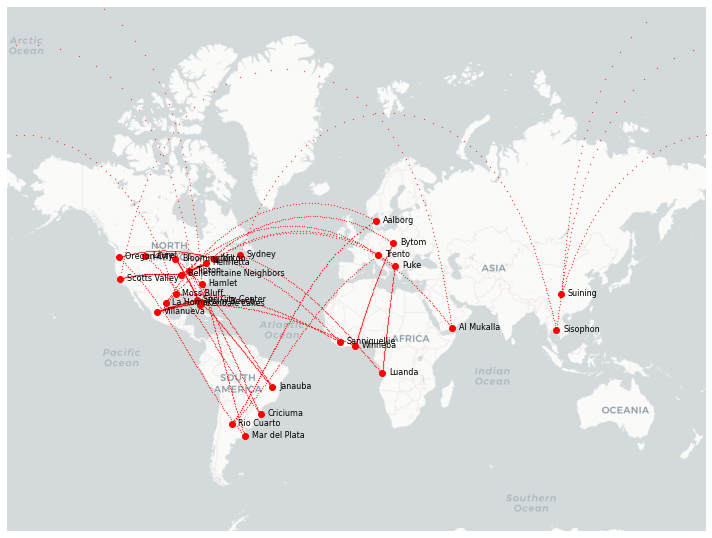

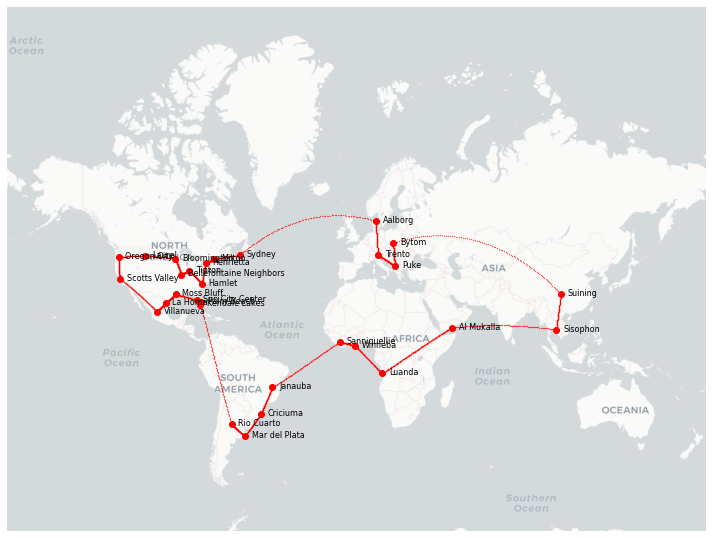

In [25]:
fig, ax = random_solution.print_route(random_solution.initial_route)
fig2, ax2 = random_solution.print_route(random_solution.best_route)

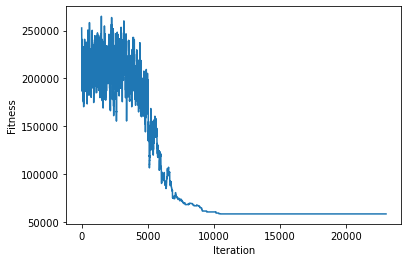

In [26]:
fig3, ax3=plt.subplots()
ax3.plot([i for i in range(len(random_solution.fitness_list))], random_solution.fitness_list)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Fitness')
plt.show()

In [27]:
random_solution.fitness(random_solution.initial_route)

252699.31017310522

## Shortest route between the 25 most populous cities

In [28]:
max_ind = np.argsort(pop)
max_cities = city[max_ind[-25:]]
max_lats = lat[max_ind[-25:]]
max_lons = lon[max_ind[-25:]]

In [29]:
max_soln = SalesmanAnneal(max_lats, max_lons, max_cities, worldmap,stopping_iter=-1)
max_soln.anneal()

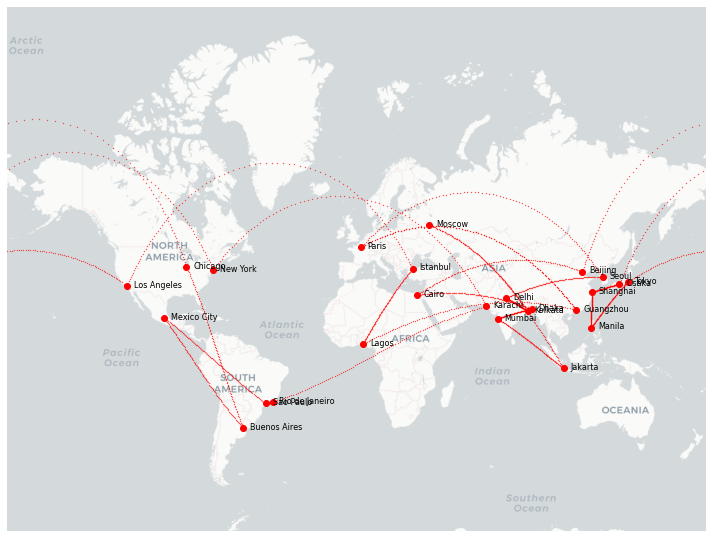

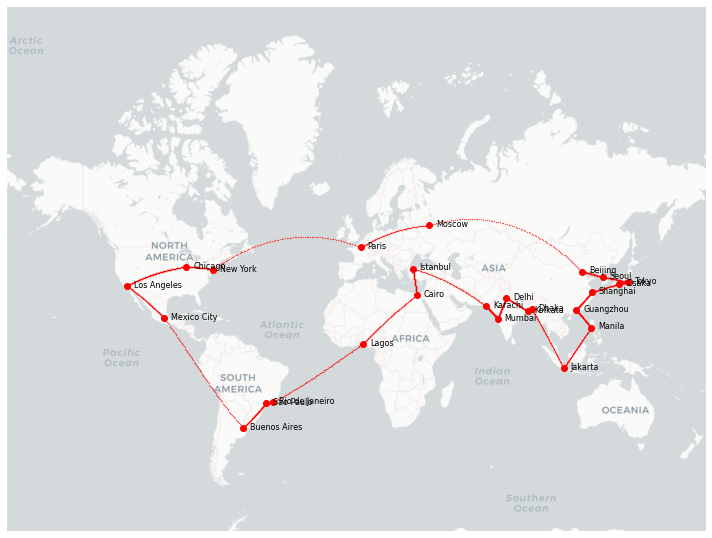

In [30]:
fig4, ax4 = max_soln.print_route(max_soln.initial_route)
fig5, ax5 = max_soln.print_route(max_soln.best_route)

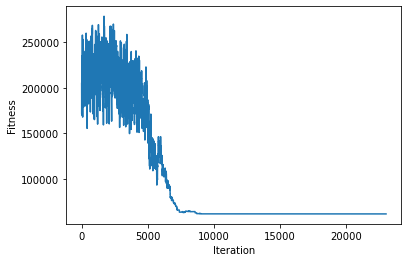

In [31]:
fig6, ax6=plt.subplots()
ax6.plot([i for i in range(len(max_soln.fitness_list))], max_soln.fitness_list)
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Fitness')
plt.show()

## Finding the shortest route around Irish Cities

In [32]:
ire_ind = np.where(country == 'IRL')

ire_cities = city[ire_ind]
ire_lats = lat[ire_ind]
ire_lons = lon[ire_ind]

In [33]:
ire_soln = SalesmanAnneal(ire_lats, ire_lons, ire_cities, dublinmap,stopping_iter=-1)
ire_soln.anneal()

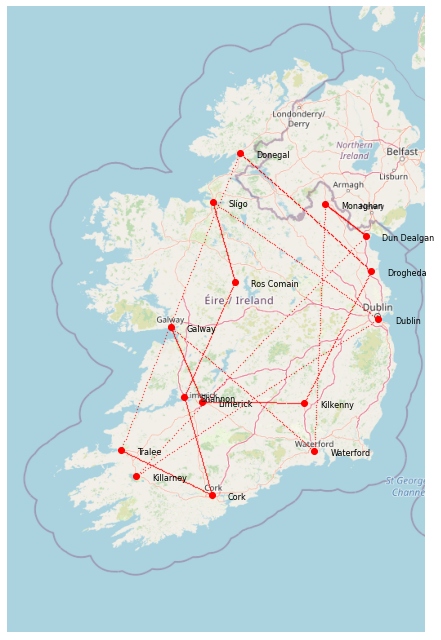

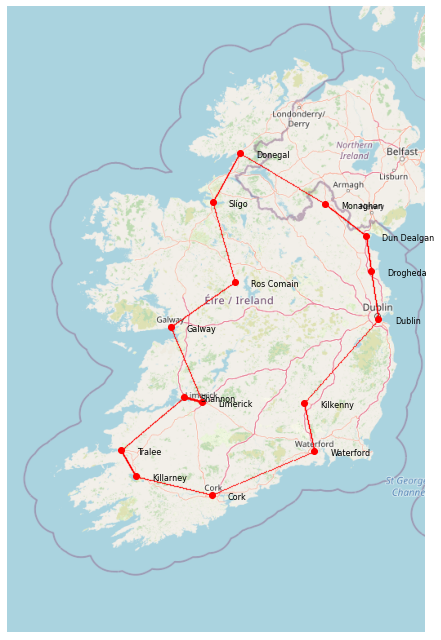

In [34]:
fig7, ax7 = ire_soln.print_route(ire_soln.initial_route)
fig8, ax8 = ire_soln.print_route(ire_soln.best_route)

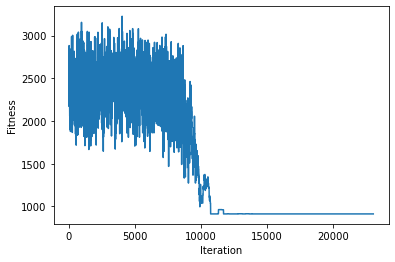

In [35]:
fig9, ax9=plt.subplots()
ax9.plot([i for i in range(len(ire_soln.fitness_list))], ire_soln.fitness_list)
ax9.set_xlabel('Iteration')
ax9.set_ylabel('Fitness')
plt.show()